# Clustering-to-Classification Code Challenge
## Mengtong Zhang

### Background of Data
In this code challenge, the dataset 'TV News Channel Commercial Detection Dataset' comes from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/TV+News+Channel+Commercial+Detection+Dataset). 

Automatic identification of commercial blocks in news videos finds a lot of applications in the domain of television broadcast analysis and monitoring. Manual segmentation of commercials from thousands of TV news channels is time consuming, and economically infeasible hence prompts the need for machine learning based Method. Classifying TV News commercials is a semantic video classification problem. TV News commercials on particular news channel are combinations of video shots uniquely characterized by audio-visual presentation. The dataset contains data of various audio visual features extracted from video shots of 5 chanels: CNNIBN, NDTV 24X7, TIMESNOW, BBC and CNN. In this challenge, only data of BBC is selected to perform the clustering-classification task due to the large volumn of data.

### Diagram of model
![Image of Diagram](http://mtzhang.georgetown.domains/diagram.png)

### Data Cleaning

The raw data is in Lib SVM data format, which is shown below.
![Image of Rawdata](http://mtzhang.georgetown.domains/bbc.jpeg)


After converted in to record data, features with missing values are removed. That is because all the columns in BBC dataset with missing values have at least 30% data missing, thus it is difficult to estimate missing values without removing them. 

The cleaned dataset has 17720 records and 20 features.

In [3]:
############## Data Cleaning #####################
import pandas as pd
import re
import os
os.chdir('/Users/zmt/Desktop/TV_News_Channel_Commercial_Detection_Dataset')
#define the function for cleaning each dataset
def clean(file):
    df=pd.read_table(file,header=None)
    s=df[0].str.split(' ')
    for x in s:
        x[0]=re.sub('^','Label:',x[0])
    m=[list(w for w in x if w) for x in s]
    d=[dict(w.split(':') for w in x) for x in m]
    cols=sorted(d,key=len,reverse=True)[0].keys()
    df=pd.DataFrame.from_records(d,index=df.index,columns=cols)
    df_cols=list(df.columns)
    df_cols.remove('Label')
    df_cols=list(map(int,df_cols))
    df_cols.sort()
    df_cols=list(map(str,df_cols))
    df_cols.append('Label')
    df=df[df_cols]
    return df
mydata=clean('BBC.txt')
#only keep the columns with no missing values
mydata=mydata.iloc[:,list(mydata.isnull().sum()==0)]
name=['Shot Length','Motion Distribution(mean)','Motion Distribution(variance)',\
      'Frame Difference Distribution (mean)','Frame Difference Distribution (variance)','Short time energy (mean)',\
      'Short time energy (variance)','ZCR (mean)','ZCR (variance)','Spectral Centroid (mean)','Spectral Centroid (variance)',\
     'Spectral Roll off (mean)','Spectral Roll off (variance)','Spectral Flux (mean)','Spectral Flux (variance)',\
     'Fundamental Frequency (mean)','Fundamental Frequency (variance)','Edge change Ratio (mean)','Edge change Ratio (variance)','Label']
mydata.columns=name
print('The shape of dataset is:',mydata.shape)
mydata.head()

The shape of dataset is: (17720, 20)


,Shot Length,Motion Distribution(mean),Motion Distribution(variance),Frame Difference Distribution (mean),Frame Difference Distribution (variance),Short time energy (mean),Short time energy (variance),ZCR (mean),ZCR (variance),Spectral Centroid (mean),Spectral Centroid (variance),Spectral Roll off (mean),Spectral Roll off (variance),Spectral Flux (mean),Spectral Flux (variance),Fundamental Frequency (mean),Fundamental Frequency (variance),Edge change Ratio (mean),Edge change Ratio (variance),Label
0,123,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,3808.067871,702.992493,7533.133301,1390.499268,971.098511,1894.978027,114.965019,45.018257,0.422333825949,0.663917631952,1
1,124,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,3466.266113,904.122925,7580.040039,1391.858643,724.249573,1722.364502,110.605591,47.206207,0.33266418864,0.766183685153,1
2,109,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,3798.196533,745.916321,7490.365723,1466.404785,1430.728149,2264.551025,139.833878,51.343670,0.346673819286,0.225022420218,1
3,86,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,3761.712402,840.047485,7411.335938,1639.901367,1154.446777,1610.234619,144.305328,50.244751,0.99332283165,0.840082960689,1
4,76,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,3784.488037,892.398682,7297.695801,1726.300415,1548.101074,1549.001587,131.560104,50.382572,0.341520175002,0.710470129795,1


### Data Clustering
In this part, Kmeans and WARD are used to compare the goodness of clustering. Kmeans is a partitional clustering method, while WARD is a hierarchical one. Kmeans is faster than WARD but is not robust to outliers and noise. WARD's performance improves when the number of clusters increases. 

To decide which algorithm to use, the number of clusters should be determined first. Before clustering, the data has been normalized to give the same importance to all the variables.


In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn import preprocessing
import pylab as pl
from sklearn import decomposition
from pprint import pprint
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabaz_score
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.options.mode.chained_assignment = None  # default='warn'
#remove the label column
df=mydata.drop(columns=['Label'])
df.head()

,Shot Length,Motion Distribution(mean),Motion Distribution(variance),Frame Difference Distribution (mean),Frame Difference Distribution (variance),Short time energy (mean),Short time energy (variance),ZCR (mean),ZCR (variance),Spectral Centroid (mean),Spectral Centroid (variance),Spectral Roll off (mean),Spectral Roll off (variance),Spectral Flux (mean),Spectral Flux (variance),Fundamental Frequency (mean),Fundamental Frequency (variance),Edge change Ratio (mean),Edge change Ratio (variance)
0,123,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,3808.067871,702.992493,7533.133301,1390.499268,971.098511,1894.978027,114.965019,45.018257,0.422333825949,0.663917631952
1,124,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,3466.266113,904.122925,7580.040039,1391.858643,724.249573,1722.364502,110.605591,47.206207,0.33266418864,0.766183685153
2,109,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,3798.196533,745.916321,7490.365723,1466.404785,1430.728149,2264.551025,139.833878,51.343670,0.346673819286,0.225022420218
3,86,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,3761.712402,840.047485,7411.335938,1639.901367,1154.446777,1610.234619,144.305328,50.244751,0.99332283165,0.840082960689
4,76,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,3784.488037,892.398682,7297.695801,1726.300415,1548.101074,1549.001587,131.560104,50.382572,0.341520175002,0.710470129795


In [23]:
############### Data Clustering ###############
#compare two clustering algorithms, and define the best number of clusters
def cluster(myData):
    x = np.array(myData.values.tolist()).astype(np.float64)
    #normalization
    minmax = preprocessing.MinMaxScaler()
    xscale = minmax.fit_transform(x)
    normalizedDataFrame = pd.DataFrame(xscale)
    print("Using Kmeans:")
    for k in range(2,10):
        start = time.time()
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(normalizedDataFrame)
        end = time.time()
        # Determine if the clustering is good using silhouette score
        silhouette_avg = silhouette_score(normalizedDataFrame, cluster_labels)
        print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg,'(time:',end-start,'s)')
        
    print("Using WARD:")
    for k in range(2,10):
        start = time.time()
        ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
        cluster_labels = ward.fit_predict(normalizedDataFrame)
        end = time.time()
        # Determine if the clustering is good using silhouette score
        silhouette_avg = silhouette_score(normalizedDataFrame, cluster_labels)
        print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg,'(time:',end-start,'s)')
#Clustering
cluster(df)

Using Kmeans:
For n_clusters = 2 The average silhouette_score is : 0.6257512806426381 (time: 0.2358698844909668 s)
For n_clusters = 3 The average silhouette_score is : 0.31619518105966177 (time: 0.4840424060821533 s)
For n_clusters = 4 The average silhouette_score is : 0.29742596279788713 (time: 0.7778589725494385 s)
For n_clusters = 5 The average silhouette_score is : 0.29114083731713186 (time: 1.1275367736816406 s)
For n_clusters = 6 The average silhouette_score is : 0.28485063349953793 (time: 1.9910790920257568 s)
For n_clusters = 7 The average silhouette_score is : 0.19647784929081533 (time: 2.674414873123169 s)
For n_clusters = 8 The average silhouette_score is : 0.19914779814654127 (time: 2.149090051651001 s)
For n_clusters = 9 The average silhouette_score is : 0.19401038459031333 (time: 2.3344902992248535 s)
Using WARD:
For n_clusters = 2 The average silhouette_score is : 0.6257589042896118 (time: 34.96678686141968 s)
For n_clusters = 3 The average silhouette_score is : 0.300933

Having tried two algorithms with number of clusters = 2 to 9, the silhouette score shows that 2 is the best number of clusters. It makes sense because BBC data comes from two classes: commercial and non-commercial. WARD is for less efficient than Kmeans from the recorded running time.

Due to the efficiency and small number of clusters, Kmeans is decided to be the algorithm for clustering BBC data. Also, the clusters are plotted on 2D using PCA. 

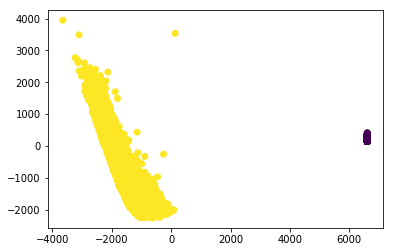

In [5]:
#Clustering with WARD, number of clusters=2
x = np.array(df.values.tolist()).astype(np.float64)
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(x)
#Using PCA to make the plot the clusters
pca2D = decomposition.PCA(2)
plot_columns = pca2D.fit_transform(x)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=cluster_labels)
plt.show()

From the plots of the clustering result, the two clusters are well separated.

### Classification
In this part, different machine learning algorithms are used to perform classification task. Tree based models (Decision Tree, Random Forest and Gradient Boosting Classifier), KNN and Naive Bayes show an accuracy score of 1 while SVM has misclassified several points. It is probably because the number of features is too large for SVM.

In [20]:
#Transforms the cluster labels into target variables
df['label']=cluster_labels

#Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter 
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.tree as tree
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

def machine_learning(df):
    
    array = np.array(df.values.tolist()).astype(np.float64)
    X = array[:, 0:19]
    Y = array[:, -1]

    # Define test size and random seed
    test_size = 0.20
    seed = 50

    # Splitting training and validation dataset
    X_train, X_validate, Y_train, Y_validate = \
    model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    # Setup 10-fold cross validation to estimate the accuracy of different models
    # Split data into 10 parts
    # Test options and evaluation metric
    num_folds = 10
    #num_instances = len(X_train)
    seed = 10
    scoring = 'accuracy'
    
    # Add each algorithm and its name to the model array
    models = []

    models.append(('Decision Tree', tree.DecisionTreeClassifier()))
    models.append(('Random Forest', RandomForestClassifier(n_estimators=10)))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('Gaussian Naive Bayes', GaussianNB()))
    models.append(('SVM', SVC(gamma='scale')))
    models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

    # Evaluate each model, add results to a results array,
    # Print the accuracy results (remember these are averages and std
    results = []
    names = []
    print("\nAccuracy during training:\n")
    for name, model in models:
        kfold = model_selection.KFold( n_splits=num_folds, 
                                      random_state=seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

machine_learning(df)


Accuracy during training:

Decision Tree: 1.000000 (0.000000)
Random Forest: 1.000000 (0.000000)
KNN: 1.000000 (0.000000)
Gaussian Naive Bayes: 1.000000 (0.000000)
SVM: 0.999929 (0.000212)
Gradient Boosting Classifier: 1.000000 (0.000000)


To sum up, random forest is chosen for classification because it is a relatively simple model, also robust to outliers and missing values.

In [19]:
array = np.array(df.values.tolist()).astype(np.float64)
X = array[:, 0:19]
Y = array[:, -1]
X_train, X_test, Y_train, Y_test = \
    model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
rf=RandomForestClassifier(n_estimators=10)
model=rf.fit(X_train,Y_train)
Y_pred = dt.predict(X_test)
print("\nAccuracy score: ",accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix: \n",confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))


Accuracy score:  1.0

Confusion Matrix: 
 [[1234    0]
 [   0 4082]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1234
         1.0       1.00      1.00      1.00      4082

   micro avg       1.00      1.00      1.00      5316
   macro avg       1.00      1.00      1.00      5316
weighted avg       1.00      1.00      1.00      5316



The confusion matrix and classification report show that random forest model classify the data points perfectly with no misclassification and accuracy score=1.